In [1]:
from itertools import product, combinations, permutations
import keyboard
import pyautogui as g
import time
import pytesseract
import random
import tkinter as tk
import threading
import pandas as pd
import math
import mss
import numpy as np
from PIL import Image
from pynput.mouse import Controller, Button

In [57]:
#põe o mouse na posição correta
time.sleep(2)
img = g.locateOnScreen('PokerStarsImages/referencia.png', confidence = 0.9, region = (100,0,1500,600), grayscale = True)
g.moveTo(img[0]+20, img[1]+10)
#arrasta o mouse até encaixar a tela na posição
g.dragTo(230, 40, 1)

In [58]:
pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR/tesseract'
dados = pd.read_excel('dados.xlsx')
parametros = pd.read_excel('parametros.xlsx')

suits = ('o','e','c','p')
values = (2,3,4,5,6,7,8,9,10,11,12,13,14)

mao = ['00','00']
mesa = ['00','00','00','00','00']

pessoas = [0,0,0,0,0]
pessoasI = [0,0,0,0,0]
banca = [0,0,0,0,0]
faltam = 0
pote = 0
pagar = 0
pagar2 = 0
bb = 100
num = 0
turno = 0
bancaTotal = 100*bb
bancaInicial = 0
rating = 0
apostado = [0,0,0,0,0,0]
mesmoTurno = 1
turnoPassado = 0
desistir = 0
moeda = [0,0,0,0,0,0]
moedaOld = [0,0,0,0,0,0]
bigblind = [0,0,0,0,0,0]
smallblind = [0,0,0,0,0,0]
primeiroSave = 1

tempoInicial = time.time() 
horario = time.localtime()
dia = f"{horario.tm_mday:02d}-{horario.tm_mon:02d}-{horario.tm_year}"

t = 0
for n in dados["Dias"]:
    if n == n:
        t = t + 1
        
col = dados.columns.get_loc("Dias")
lin = dados.loc[dados["Dias"] == dia].index
if (dados["Dias"] == dia).any() == False:
    dados.iloc[t, col] = dia
    dados.iloc[t, col + 1] = 0
    dados.iloc[t, col + 2] = 0
    dados.to_excel('dados.xlsx', index=False)

#define as configurações da janela
janela = tk.Tk()
largura = 176
altura = 540
posX = 6
posY = 27
janela.geometry(f"{largura}x{altura}+{posX}+{posY}")
janela.configure(background='#fd9696')

#cria os vetores com as informações e configurações do que aparecerá na janela
valores = []
for _ in range(16):
    valores.append(tk.StringVar())
rotulos = ['0']*16
titulo = tk.StringVar()
espaco = tk.StringVar()

#define as informações mostradas na janela
titulo.set('Peto 1.0')
espaco = ' '
valores[0].set('Mão: ' + str(mao[0]) + ' ' + str(mao[1]))
valores[1].set('Mesa: ' + str(mesa[0]) + ' ' + str(mesa[1]) + ' ' + str(mesa[2]) + ' ' + str(mesa[3]) + ' ' + str(mesa[4]))
valores[2].set('Pagar: ' + str(pagar))
valores[3].set('Pote: ' + str(pote))
valores[4].set('Pessoas: ' + str(pessoas[0]) + ' ' + str(pessoas[1]) + ' ' + str(pessoas[2]) + ' ' + str(pessoas[3]) + ' ' + str(pessoas[4]))
valores[5].set('Banca: ' + str(banca[0]) + ' ' + str(banca[1]) + ' ' + str(banca[2]) + ' ' + str(banca[3]) + ' ' + str(banca[4]))
valores[6].set('Faltam: ' + str(faltam))
valores[7].set('Pago no máximo: ' + '0')
valores[8].set('Apostaria: ' + '0')
valores[9].set('Minha banca: ' + '0')
valores[10].set('Rating do preflop: ' + str(rating))
valores[11].set('Winrate: ' + '0')
valores[12].set('Tierate: ' + '0')
valores[13].set('Winrate ajustado: ' + '0')
valores[14].set('Apostado : ' + str(apostado[1]) + ' ' + str(apostado[2]) + ' ' + str(apostado[3]) + ' ' + str(apostado[4]) + ' ' + str(apostado[5]))
valores[15].set('Esperando minha vez')

rotulo2 = tk.Label(janela, background='#fd9696', textvariable=espaco)
rotulo2.pack()
rotulo1 = tk.Label(janela, background='#fd9696', textvariable=titulo)
rotulo1.pack()
rotulo2 = tk.Label(janela, background='#fd9696', textvariable=espaco)
rotulo2.pack()
#lançara as informações na janela, dando um espaço de 1 linha vazia antes de lançar a última informação
for r in range(len(rotulos)-1):
    rotulos[r] = tk.Label(janela, background='#fd9696', textvariable=valores[r])
    rotulos[r].pack()
rotulo2 = tk.Label(janela, background='#fd9696', textvariable=espaco)
rotulo2.pack()
rotulos[15] = tk.Label(janela, background='#fd9696', textvariable=valores[15])
rotulos[15].pack()

maos = {
    (14, 14, 0): 169, (13, 13, 0): 168, (12, 12, 0): 167, (14, 13, 1): 166, (11, 11, 0): 165,
    (14, 12, 1): 164, (13, 12, 1): 163, (14, 11, 1): 162, (13, 11, 1): 161, (10, 10, 0): 160,
    (14, 13, 0): 159, (14, 10, 1): 158, (12, 11, 1): 157, (13, 10, 1): 156, (12, 10, 1): 155,
    (11, 10, 1): 154, (9, 9, 0): 153, (14, 12, 0): 152, (14, 9, 1): 151, (13, 12, 0): 150,
    (8, 8, 0): 149, (13, 9, 1): 148, (10, 9, 1): 147, (14, 8, 1): 146, (12, 9, 1): 145,
    (11, 9, 1): 144, (14, 11, 0): 143, (14, 5, 1): 142, (7, 7, 0): 141, (14, 7, 1): 140,
    (13, 11, 0): 139, (14, 4, 1): 138, (14, 3, 1): 137, (14, 6, 1): 136, (12, 11, 0): 135,
    (6, 6, 0): 134, (13, 8, 1): 133, (10, 8, 1): 132, (14, 2, 1): 131, (9, 8, 1): 130,
    (11, 8, 1): 129, (14, 10, 0): 128, (12, 8, 1): 127, (13, 7, 1): 126, (13, 10, 0): 125,
    (5, 5, 0): 124, (11, 10, 0): 123, (8, 7, 1): 122, (12, 10, 0): 121, (4, 4, 0): 120,
    (3, 3, 0): 119, (2, 2, 0): 118, (13, 6, 1): 117, (9, 7, 1): 116, (13, 5, 1): 115,
    (7, 6, 1): 114, (10, 7, 1): 113, (13, 4, 1): 112, (13, 3, 1): 111, (13, 2, 1): 110,
    (12, 7, 1): 109, (8, 6, 1): 108, (6, 5, 1): 107, (11, 7, 1): 106, (5, 4, 1): 105,
    (12, 6, 1): 104, (7, 5, 1): 103, (9, 6, 1): 102, (12, 5, 1): 101, (6, 4, 1): 100,
    (12, 4, 1): 99, (12, 3, 1): 98, (10, 9, 0): 97, (10, 6, 1): 96, (12, 2, 1): 95,
    (14, 9, 0): 94, (5, 3, 1): 93, (8, 5, 1): 92, (11, 6, 1): 91, (11, 9, 0): 90,
    (13, 9, 0): 89, (11, 5, 1): 88, (12, 9, 0): 87, (4, 3, 1): 86, (7, 4, 1): 85,
    (11, 4, 1): 84, (11, 3, 1): 83, (9, 5, 1): 82, (11, 2, 1): 81, (6, 3, 1): 80,
    (14, 8, 0): 79, (5, 2, 1): 78, (10, 5, 1): 77, (8, 4, 1): 76, (10, 4, 1): 75,
    (10, 3, 1): 74, (4, 2, 1): 73, (10, 2, 1): 72, (9, 8, 0): 71, (10, 8, 0): 70,
    (14, 5, 0): 69, (14, 7, 0): 68, (7, 3, 1): 67, (14, 4, 0): 66, (3, 2, 1): 65,
    (9, 4, 1): 64, (9, 3, 1): 63, (11, 8, 0): 62, (14, 3, 0): 61, (6, 2, 1): 60,
    (9, 2, 1): 59, (13, 8, 0): 58, (14, 6, 0): 57, (8, 7, 0): 56, (12, 8, 0): 55,
    (8, 3, 1): 54, (14, 2, 0): 53, (8, 2, 1): 52, (9, 7, 0): 51, (7, 2, 1): 50,
    (7, 6, 0): 49, (13, 7, 0): 48, (6, 5, 0): 47, (10, 7, 0): 46, (13, 6, 0): 45,
    (8, 6, 0): 44, (5, 4, 0): 43, (13, 5, 0): 42, (11, 7, 0): 41, (7, 5, 0): 40,
    (12, 7, 0): 39, (13, 4, 0): 38, (13, 3, 0): 37, (9, 6, 0): 36, (13, 2, 0): 35,
    (6, 4, 0): 34, (12, 6, 0): 33, (5, 3, 0): 32, (8, 5, 0): 31, (10, 6, 0): 30,
    (12, 5, 0): 29, (4, 3, 0): 28, (12, 4, 0): 27, (12, 3, 0): 26, (7, 4, 0): 25,
    (12, 2, 0): 24, (11, 6, 0): 23, (6, 3, 0): 22, (11, 5, 0): 21, (9, 5, 0): 20,
    (5, 2, 0): 19, (11, 4, 0): 18, (11, 3, 0): 17, (4, 2, 0): 16, (11, 2, 0): 15,
    (8, 4, 0): 14, (10, 5, 0): 13, (10, 4, 0): 12, (3, 2, 0): 11, (10, 3, 0): 10,
    (7, 3, 0): 9, (10, 2, 0): 8, (6, 2, 0): 7, (9, 4, 0): 6, (9, 3, 0): 5,
    (9, 2, 0): 4, (8, 3, 0): 3, (8, 2, 0): 2, (7, 2, 0): 1
}

print('rodando')

#variáveis que serão salvar ao final da partida
apostaMinimaD = ''
pagueiD = ''
faltamD = ''
pessoasD = ''
poteD = ''
winrateD = ''
turnoD = ''
mesmoTurnoD = ''

a = parametros['Parametros'][0]
a = a.split(',')
faltamP = [float(n) for n in a]

a = parametros['Parametros'][1]
a = a.split(',')
mesmoTurnoP = [float(n) for n in a]

a = parametros['Parametros'][2]
a = a.split(',')
pagarP = [float(n) for n in a]

a = parametros['Parametros'][3]
a = a.split(',')
poteP = [float(n) for n in a]

bbd = np.array(dados["BB"].astype(float))
bbd = bbd.reshape(len(bbd),1)
bbd = np.reciprocal(bbd)

retorn = np.array(dados["Retorno"].astype(float))
retorn = retorn.reshape(1,len(retorn))
mediaRetorno = retorn.dot(bbd)/(len(bbd))
mediaRetorno = mediaRetorno[0][0]

countTurno = [0,0,0,0]
mediaMesmoTurno = [0,0,0,0]
mediaApostaMinima = [0,0,0,0]
mediaPote = [0,0,0,0]
mediaFaltam = [0,0,0,0]
for i in range(len(dados["Turno"])):
    a = dados["Turno"][i].split(';')[:-1]
    b = dados["Mesmo Turno"][i].split(';')[:-1]
    c = dados["Aposta Minima"][i].split(';')[:-1]
    d = dados["Pote"][i].split(';')[:-1]
    e = dados["Faltam"][i].split(';')[:-1]
    for j in range(len(a)):
        countTurno[int(a[j]) - 1] = countTurno[int(a[j]) - 1] + 1
        mediaMesmoTurno[int(a[j]) - 1] = mediaMesmoTurno[int(a[j]) - 1] + int(b[j])
        mediaApostaMinima[int(a[j]) - 1] = mediaApostaMinima[int(a[j]) - 1] + int(c[j])
        mediaPote[int(a[j]) - 1] = mediaPote[int(a[j]) - 1] + int(d[j])
        mediaFaltam[int(a[j]) - 1] = mediaFaltam[int(a[j]) - 1] + int(e[j])
for i in range(4):
    mediaMesmoTurno[i] = mediaMesmoTurno[i]/countTurno[i]
    mediaApostaMinima[i] = mediaApostaMinima[i]/countTurno[i]
    mediaPote[i] = mediaPote[i]/countTurno[i]
    mediaFaltam[i] = mediaFaltam[i]/countTurno[i]


def Calcular():
    
    valores[15].set('Calculando as probabilidades')
    #une todas as combinações entre naipes e valores, formando todas as 52 cartas do baralho
    deck = [str(card[0]) + card[1] for card in list(product(values, suits))]
    #remove do baralho as cartas que estão na mão e na mesa
    deck.pop(deck.index(mao[0])) 
    deck.pop(deck.index(mao[1]))
    for i in mesa:
        if i in deck:
            deck.pop(deck.index(i))

    #define o turno com base no número de cartas na mesa

    win = 0
    lose = 0
    tie = 0
    
    winRating = 0
    tieRating = 0
    loseRating = 0
    
    winstr = 0
    winflush = 0
    
    winstrRating = 0
    winflushRating = 0
    
    apostadoInicio = 0
    for d in range(len(pagueiD.split(';')[:-1])):
        if turnoD.split(';')[:-1][d] == '1':
            apostadoInicio = apostadoInicio + int(pagueiD.split(';')[:-1][d])
    if bigblind[0] == 1:
        apostadoInicio = apostadoInicio + bb
    elif smallblind[0] == 1:
        apostadoInicio = apostadoInicio + bb/2
        
    peso = (apostadoInicio/bb)**(1/2.5)/2.5
    
        #para cada possibilidade de cartas na mesa e na mão do adversário roda uma vez o código
    vezes = round(8000/pessoas**0.75)
    for y in range(vezes):
        
        nCartas = num + pessoas*2
        
        t = random.sample(deck, nCartas)
            
        jogadas = []
        ratings = []
        for u in range(1 + pessoas):
            jogadas.append([0,0,0,0,0,0])
            ratings.append(0)

        #roda uma vez para a mão e uma vez para a mão do adversário
        for k in range(1 + pessoas):
            #O primeiros valores são os mais importantes na decisão de quem ganha e os ultimos são
            #menos importantes, como a terceira carta alta de um par
            par = [0,0,0,0]
            pares = [0,0,0]
            trinca = [0,0,0]
            fullHouse = [0,0]
            quadra = [0,0]
            sequ = 0
            naipeFlush = [0,'0',0,0,0,0]
            strflush = [0,'0']

            if turno == 1:
                if k == 0:
                    jogada = [mao[0],mao[1],t[0],t[1],t[2],t[3],t[4]]
                else:
                    jogada = [t[num + k*2 - 2],t[num + k*2 - 1],t[0],t[1],t[2],t[3],t[4]]
            elif turno == 2:
                if k == 0:
                    jogada = [mao[0],mao[1],mesa[0],mesa[1],mesa[2],t[0],t[1]]
                else:
                    jogada = [t[num + k*2 - 2],t[num + k*2 - 1],mesa[0],mesa[1],mesa[2],t[0],t[1]]
            elif turno == 3:
                if k == 0:
                    jogada = [mao[0],mao[1],mesa[0],mesa[1],mesa[2],mesa[3],t[0]]
                else:
                    jogada = [t[num + k*2 - 2],t[num + k*2 - 1],mesa[0],mesa[1],mesa[2],mesa[3],t[0]]
            elif turno == 4:
                if k == 0:
                    jogada = [mao[0],mao[1],mesa[0],mesa[1],mesa[2],mesa[3],mesa[4]]
                else:
                    jogada = [t[num + k*2 - 2],t[num + k*2 - 1],mesa[0],mesa[1],mesa[2],mesa[3],mesa[4]]

            #cria um vetor com apenas os valores das cartas
            seq = [int(jogada[0][:-1]),int(jogada[1][:-1]),int(jogada[2][:-1]),int(jogada[3][:-1]),int(jogada[4][:-1]),int(jogada[5][:-1]),int(jogada[6][:-1])]
            #remove os valores repetidos e depois os ordena em ordem crescente
            straight = set(seq)
            straight = sorted(straight)

            #interpreta a possibilidade de uma sequencia que começa com a carta 'A'
            if 2 in straight and 3 in straight and 4 in straight and 5 in straight and 14 in straight and 6 not in straight:
                straight = [1,2,3,4,5]

            #detecta se no vetor de cartas sem números repetidos tem pelo menos 5 cartas diferentes
            l = len(straight)
            if l > 4:
                #caso exista uma sequencia, o valor de uma carta somado a 4 será igual ao da quinta carta,
                #pois elas estão em ordem e não existe repetição de cartas
                if l == 5:
                    if straight[0] + 4 == straight[4]:
                        sequ = straight[4]
                elif l == 6:
                    if straight[1] + 4 == straight[5]:
                        sequ = straight[5]
                    elif straight[0] + 4 == straight[4]:
                        sequ = straight[4]
                elif l == 7:
                    if straight[2] + 4 == straight[6]:
                        sequ = straight[6]
                    elif straight[1] + 4 == straight[5]:
                        sequ = straight[5]
                    elif straight[0] + 4 == straight[4]:
                        sequ = straight[4]

            #conta quantas cartas de cada naipe existem
            countFlush = [0,0,0,0]
            for a in jogada:
                if a[-1] == 'o':
                    countFlush[0] = countFlush[0] + 1
                elif a[-1] == 'e':
                    countFlush[1] = countFlush[1] + 1
                elif a[-1] == 'c':
                    countFlush[2] = countFlush[2] + 1
                else:
                    countFlush[3] = countFlush[3] + 1

            #verifica se houve um flush
            if countFlush[0] > 4:
                naipeFlush[1] = 'o'
            elif countFlush[1] > 4:
                naipeFlush[1] = 'e'
            elif countFlush[2] > 4:
                naipeFlush[1] = 'c'
            elif countFlush[3] > 4:
                naipeFlush[1] = 'p'


            seqflush = []
            #cria um vetor com os numeros em ordem crescente das cartas que formaram o flush
            for c in jogada:
                if naipeFlush[1] == c[-1]:
                    seqflush.append(c)
            seqflus = []
            for f in seqflush:
                seqflus.append(int(f[:-1]))
            seqflus.sort()           
            if 2 in seqflus and 3 in seqflus and 4 in seqflus and 5 in seqflus and 14 in seqflus and 6 not in seqflus:
                seqflus = [1,2,3,4,5]
            #detecta se existe uma sequencia nas carta que compuseram o flush e também cria a ordem de cartas altas do flush
            l = len(seqflus)
            if l == 5:
                naipeFlush = [seqflus[4],naipeFlush[1],seqflus[3],seqflus[2],seqflus[1],seqflus[0]]
                if seqflus[0] + 4 == seqflus[4]:
                    strflush[0] = seqflus[4]
            elif l == 6:
                naipeFlush = [seqflus[5],naipeFlush[1],seqflus[4],seqflus[3],seqflus[2],seqflus[1]]
                if seqflus[1] + 4 == seqflus[5]:
                    strflush[0] = seqflus[5]
                elif seqflus[0] + 4 == seqflus[4]:
                    strflush[0] = seqflus[4]
            elif l == 7:
                naipeFlush = [seqflus[6],naipeFlush[1],seqflus[5],seqflus[4],seqflus[3],seqflus[2]]
                if seqflus[2] + 4 == seqflus[6]:
                    strflush[0] = seqflus[6]
                elif seqflus[1] + 4 == seqflus[5]:
                    strflush[0] = seqflus[5]
                elif seqflus[0] + 4 == seqflus[4]:
                    strflush[0] = seqflus[4]
            if strflush[0] > 0:
                strflush[1] = naipeFlush[1]

            #ordena o vetor seq, que contem o valor dar cartas, em ordem decrescente
            seq.sort(reverse=True)
            #conta quantas vezes cada valor aparece para detectar as jogadas
            for a in seq:
                count = seq.count(a)
                if count == 4:
                    quadra[0] = a
                elif count == 3:
                    trinca[0] = a
                    if fullHouse[0] == 0:
                        fullHouse[0] = a
                    elif a != fullHouse[0]:
                        fullHouse[1] = a
                elif count == 2:
                    par[0] = a
                    if fullHouse[1] == 0:
                        fullHouse[1] = a
                    if pares[0] == 0:
                        pares[0] = a
                    elif pares[1] == 0 and pares[0] != a:
                        pares[1] = a

            #organiza a ordem das cartas altas para as jogadas
            for x in jogada:
                v = int(x[:-1])
                if v > par[1] and v != par[0]:
                    par[3], par[2], par[1] = par[2], par[1], v
                elif v > par[2] and v != par[0]:
                    par[3], par[2] = par[2], v
                elif v > par[3] and v != par[0]:
                    par[3] = v

                if v > pares[2] and v != pares[0] and v != pares[1]:
                    pares[2] = v

                if v > trinca[1] and v != trinca[0]:
                    trinca[2], trinca[1] = trinca[1], v
                elif v > trinca[2] and v != trinca[0]:
                    trinca[2] = v

                if v > quadra[1] and v != quadra[0]:
                    quadra[1] = v

            #inverte o straight, que contem as cartas sem repetição em ordem crescente, para indicar cartas altas
            straight.sort(reverse = True)

            #escolhe a melhor jogada, indicando qual é a jogada e quais as cartas altas
            if strflush[0] != 0:
                jogadas[k][0]=strflush[0]
                jogadas[k][5]=9
            elif quadra[0] > 0:
                jogadas[k][0]=quadra[0]
                jogadas[k][1]=quadra[1]
                jogadas[k][5]=8
            elif fullHouse[0] > 0 and fullHouse[1] > 0:
                jogadas[k][0]=fullHouse[0]
                jogadas[k][1]=fullHouse[1]
                jogadas[k][5]=7
            elif naipeFlush[0] > 0:
                jogadas[k][0]=naipeFlush[0]
                jogadas[k][1]=naipeFlush[2]
                jogadas[k][2]=naipeFlush[3]
                jogadas[k][3]=naipeFlush[4]
                jogadas[k][4]=naipeFlush[5]
                jogadas[k][5]=6
            elif sequ > 0:
                jogadas[k][0]=sequ
                jogadas[k][5]=5
            elif trinca[0] > 0:
                jogadas[k][0]=trinca[0]
                jogadas[k][1]=trinca[1]
                jogadas[k][2]=trinca[2]
                jogadas[k][5]=4
            elif pares[0] > 0 and pares[1] > 0:
                jogadas[k][0]=pares[0]
                jogadas[k][1]=pares[1]
                jogadas[k][2]=pares[2]
                jogadas[k][5]=3
            elif par[0] > 0:
                jogadas[k][0]=par[0]
                jogadas[k][1]=par[1]
                jogadas[k][2]=par[2]
                jogadas[k][3]=par[3]
                jogadas[k][5]=2
            else:
                jogadas[k][0]=straight[0]
                jogadas[k][1]=straight[1]
                jogadas[k][2]=straight[2]
                jogadas[k][3]=straight[3]
                jogadas[k][4]=straight[4]
                jogadas[k][5]=1

            for r in range(pessoas):
                maoAdv1 = [jogada[0], jogada[1]]
                maoAdv2 = [int(jogada[0][:-1]),int(jogada[1][:-1]),0]

                if maoAdv2[0] < maoAdv2[1]:
                    maoAdv2[0], maoAdv2[1] = maoAdv2[1], maoAdv2[0]

                maoAdv2[2] = 1 if maoAdv1[0][-1] == maoAdv1[1][-1] else 0

                #determina o rating da minha mao entre as 169 maos possíveis
                ratings[r + 1] = maos.get(tuple(maoAdv2), 0)   
            
        maoAdvRating = sum(ratings)/pessoas

        #verifica qual partipante tem a melhor jogada, usando os critérios de desempate
        #se o jogar ganhar graças a um flush ou uma sequencia, esses valores serão salvos
        jogada = jogadas.copy()
        x = [x[5] for x in jogada]
        x = max(x)
        pop = 0
        for i in range(len(jogada)):
            if jogada[i - pop][5] != x:
                jogada.pop(i - pop)
                pop = pop + 1
        if len(jogada) > 1:
            for j in range(5):
                x = [x[j] for x in jogada]
                x = max(x)
                pop = 0
                for i in range(len(jogada)):
                    if jogada[i - pop][j] != x:
                        jogada.pop(i - pop)
                        pop = pop + 1
                if len(jogada) == 1:
                    break

        if jogadas[0] not in jogada:
            lose = lose + 1
            loseRating = loseRating + (maoAdvRating**peso)
        else:
            if len(jogada) > 1:
                tie = tie + 1
                tieRating = tieRating + (maoAdvRating**peso)
            else:
                win = win + 1
                winRating = winRating + (maoAdvRating**peso)
                if jogadas[0][5] == 6:
                    winflush = winflush + 1
                    winflushRating = winflushRating + (maoAdvRating**peso)
                elif jogadas[0][5] == 5:
                    winstr = winstr + 1
                    winstrRating = winstrRating + (maoAdvRating**peso)

    winrate = win/(win+lose+tie)
    tierate = tie/(win+lose+tie)
    
    winrateRating = winRating/(winRating+loseRating+tieRating)
    tierateRating = tieRating/(winRating+loseRating+tieRating)
    
    
    #quando for ou vitoria ou empate, o winrate será = 100.
    winrate = winrate + (winrate + tierate)*tierate
    winrateRating = winrateRating + (winrateRating + tierateRating)*tierateRating
    
    #caso haja muita chance de vitoria graças a um straight ou flush, isso será embutido na taxa de vitoria em
    #função da chance de derrota, representando um aumento no winrate graças a vinda de um straight ou flush
    if winflush/(win + lose + tie) < 0.5:    
        winrate = winrate + (1-winrate)*(winflush*0.4)/(win+lose+tie)
        winrateRating = winrateRating + (1-winrateRating)*(winflushRating*0.4)/(winRating+loseRating+tieRating)
    if winstr/(win + lose + tie) < 0.5:   
        winrate = winrate + (1-winrate)*(winstr*0.2)/(win+lose+tie)
        winrateRating = winrateRating + (1-winrateRating)*(winstrRating*0.2)/(winRating+loseRating+tieRating)
    
    valores[11].set('Winrate: ' + str(round(winrate*100,2)))
    valores[12].set('Tierate: ' + str(round(tierate*100,2)))
    Jogar(winrate, winrateRating)
    
     
def Jogar(winrate, winrateRating):
    
    global desistir
    
    global winrateD
    global pagueiD
    global turnoD
    
    global rating
    global desistir
    
    #padroniza o formato das cartas da mao para compara-los com as 169 maos existentes
    valores[15].set('Decidindo minha jogada')
    hand = [int(mao[0][:-1]),int(mao[1][:-1]),0]
    
    if hand[0] < hand[1]:
        hand[0], hand[1] = hand[1], hand[0]
    
    hand[2] = 1 if mao[0][-1] == mao[1][-1] else 0
    
    #determina o rating da minha mao entre as 169 maos possíveis
    rating = maos.get(tuple(hand), 0)
    
    valores[10].set('Rating do preflop: ' + str(rating))

    valores[15].set('Decidindo minha jogada')
    #o winrate será ajustado em função das variáveis da partida
    winrateD = winrateD + str(round(winrate,2)) + ';'
    
    #Quanto mais foi apostado, mais as mãos iniciais eram boas
    apostadoInicio = 0
    for d in range(len(pagueiD.split(';')[:-1])):
        if turnoD.split(';')[:-1][d] == '1':
            apostadoInicio = apostadoInicio + int(pagueiD.split(';')[:-1][d])
    if bigblind[0] == 1:
        apostadoInicio = apostadoInicio + bb
    elif smallblind[0] == 1:
        apostadoInicio = apostadoInicio + bb/2
        
        
    jaPaguei = 0
    for d in range(len(pagueiD.split(';')[:-1])):
        if turnoD.split(';')[:-1][d] == turno:
            jaPaguei = jaPaguei + int(pagueiD.split(';')[:-1][d])
         
    aumentei = 0
    for d in range(len(pagueiD.split(';')[:-1])):
        aumentei = aumentei + (int(pagueiD.split(';')[:-1][d]) - int(apostaMinimaD.split(';')[:-1][d]))*int(pessoasD.split(';')[:-1][d + 1])
        
    #caso o bigblind esteja no jogo ainda, é possível que ele tenha entrado com um mão não tão boa,
    #mas se ele apostou muito ou ainda existe muitos outros jogadores na partida é porque o winrate
    #com peso maior para mãos boas continua sendo relevante
    if pessoasI[bigblind.index(1) - 1] == 1:
        winrate = (winrate + winrateRating*((pessoas-1)/pessoas)*(apostadoInicio/(5*bb))**0.5 + winrateRating*(1/pessoas)*((apostadoInicio-bb)/(5*bb))**0.5)/(1 + ((pessoas-1)/pessoas)*(apostadoInicio/(5*bb))**0.5 + (1/pessoas)*((apostadoInicio-bb)/(5*bb))**0.5)
    else:
        winrate = (winrate + winrateRating*(apostadoInicio**0.5)/(5*(bb**0.5)))/(1 + (apostadoInicio**0.5)/(5*(bb**0.5)))
    
    #Quando faltam poucas pessoas, ou seja, se sabe como as pessoas reagiram as cartas, caso seja notado que
    #o pote cresceu muito só nesse turno, é por que a partir de agora as pessoas estão mais confiantes, então o winrate deve
    #cair e todos pararam de aumentar o pote é porque perderam a confiança após a última revelação de cartas.
    #Tudo isso ponderado pelo winrate, de forma que não seja possível passar dos 100% e nem haja nenhuma crescida brusca
    winrate = winrate + (1 - winrate)*(winrate)*((pessoas - faltam)/pessoas)*((pote/2 - pagar*(pessoas-faltam*(2/3)))/pote)*(1/mesmoTurno**3)*winrate
    
    winrate = winrate - (1 - winrate)*(winrate)*(mesmoTurnoP[turno - 1]*mesmoTurno**(1/3))
    winrate = winrate - (1 - winrate)*(winrate)*(0.2 + pagarP[turno - 1]*((pagar + apostado[0])/bb)**(1/3))*(0.2 + poteP[turno - 1]*((pote - aumentei)/bb)**(1/5))*(0.2 + faltamP[turno - 1]*(1+faltam/2)**(1/2))
    
    estPessoas =  pessoas - faltam*(1 - 1/(1 + (pagar/(0.5*(pote - (pagar + apostado[0])*(pessoas - faltam))**(mesmoTurno**0.20)))**1.5))
    
    #O numero de pessoas na mesa será menor por que muitos vao desistir graças ao tamanho da aposta minima
    winrate = winrate**(estPessoas/pessoas)
    
    winrate = winrate**(1 + faltamP[turno-1]*(1 + faltam)**(1/3))
    
    valores[13].set('Winrate ajustado: ' + str(round(winrate*100,2)))
            
        
    pago = (pote + (pagar + apostado[0])*(estPessoas + faltam - pessoas))*winrate
    
    
    aposto = (pago/3)*pessoas**0.5
    aposto = aposto - jaPaguei
    
        
    # se começar com algo muito bom, como uma trinca ou fullhouse, não aposte nada para blefar.
    if turno == 2 and winrate > 0.91 and mao[0][:-1] != mao[1][:-1]:
        aposto = 0
    
    
    # aumentar as apostas gradualmente
    if aposto > (4*pote)/3:
        aposto = (pote + aposto)/2
        
    aposto = aposto/bb
    aposto = int(round(aposto)*bb)
    
    valores[7].set('Pago no máximo: ' + str(round(pago)))
    valores[8].set('Apostaria: ' + str(round(aposto)))
    
    if aposto > pagar + apostado[0]:
        if aposto*0.2 < abs(aposto - pagar2):
            MovimentoSuave(875, 625)
            time.sleep(0.1)
            g.doubleClick()
            time.sleep(0.2)
            for f in str(aposto):
                g.write(f)
            pagueiD = pagueiD + str(round(aposto)) + ';'
        else:
            pagueiD = pagueiD + str(round(pagar2)) + ';'
        MovimentoSuave(1070, 680)
        Clique()
    elif pago >= pagar:
        if g.pixelMatchesColor(850, 655, (197, 43, 43), tolerance = 20) == False:
            MovimentoSuave(1070, 680)
            Clique()
            pagueiD = pagueiD + str(pagar) + ';'
        else:
            MovimentoSuave(910, 680)
            Clique()
            pagueiD = pagueiD + str(pagar) + ';'
    else:
        MovimentoSuave(750, 680)
        Clique()
        desistir = 1
        pagueiD = pagueiD + '0;'
            
    if g.pixelMatchesColor(1010, 655, (197, 43, 43), tolerance = 50):
        g.click()
        print('clique adicional foi necessário')
    x = random.randint(0,2)
    if x == 0:
        Humanizar()
    

    MovimentoSuave(985, 505)
    valores[15].set('Esperando minha vez')
    Esperando()


def MovimentoSuave(x,y):
    
    x = x + parametros['Aleatorizar'][3] + random.randint(-5,5)
    y = y + parametros['Aleatorizar'][4] + random.randint(-3,3)
    
    mouse = Controller()
    xInicial, yInicial = mouse.position
    dist = math.hypot(xInicial - x, yInicial - y)
    tempoInicio = time.time()
    tempo = parametros['Aleatorizar'][0]*(1 + random.random()/3)*(dist**0.5/25)
    poderCurva1 = random.random() + parametros['Aleatorizar'][1]
    poderCurva2 = random.random() + parametros['Aleatorizar'][2]
    
    if abs(xInicial - x) > 0: 
        inclin = (yInicial - y)/(xInicial - x)
    else:
        return
    
    while time.time() - tempoInicio < tempo:
        tempoPassado = time.time() - tempoInicio
        progresso = tempoPassado / tempo
        progressoAjustado = math.sin(progresso * math.pi / 2)
        
        progressoCurva = math.sin(progressoAjustado * math.pi)

        vel = 3 * (1 + random.random()/2)

        posX = xInicial + (x - xInicial) * progressoAjustado
        posY = yInicial + progressoCurva*dist/poderCurva1 + (progressoAjustado**poderCurva2)*(y - yInicial)

        mouse.position = (posX, posY)
    mouse.position = (x, y)
    
    parametros.at[5, 'Aleatorizar'] = parametros['Aleatorizar'][5] + 1
    
    if parametros['Aleatorizar'][5] > parametros['Aleatorizar'][6]:
        parametros.at[0, 'Aleatorizar'] = 0.25 + random.random()/8
        parametros.at[1, 'Aleatorizar'] = 2 + random.random()/2
        parametros.at[2, 'Aleatorizar'] = 2 + random.random()/2
        parametros.at[3, 'Aleatorizar'] = random.randint(-5,5)
        parametros.at[4, 'Aleatorizar'] = random.randint(-3,3)
        
        parametros.at[5, 'Aleatorizar'] = 0
        parametros.at[6, 'Aleatorizar'] = 50 + random.randint(0,30)
        
        parametros.at[7, 'Aleatorizar'] = random.randint(-4,4)
    
    parametros.to_excel('parametros.xlsx', index=False)
    
    
def Clique():
    mouse = Controller()
    mouse.press(Button.left)
    time.sleep(0.05 + random.random()/150)
    mouse.release(Button.left)
    
    time.sleep(0.4 + random.random()/5)
    
    x, y = g.position()[0], g.position()[1]
    MovimentoSuave(x + random.randint(-2,2), y + random.randint(-2,2))

    
def Humanizar():
    global parametros
    #colocar mais frases e tempos de espera entre as ações
    time.sleep(0.8 + random.random()/4)
    frases = ['ez', 'noobs', 'wtf', 'you are probably all bald', 'poker sucks', ':)', ':(', 'shit', ':P', 'bluff', 'shitty bluff', 'bluffed', 'keep bluffing', 'full house here', 'straight flush here', 'lame', 'hehe', 'haha', 'hoho', 'hihi']
    
    c = [380,495,445,120,785,440,1075,265,250,250]
    pos = random.randint(0,len(c)/2 - 1)
    MovimentoSuave(c[pos*2] + 2*parametros['Aleatorizar'][3] + random.randint(-10,10), c[pos*2 + 1]  + 2*parametros['Aleatorizar'][4] + random.randint(-6,6))
    
    if random.randint(0,7) == 0:
        time.sleep(0.2 + random.random()/7)
        g.click()
        
    if random.randint(0,6 - pessoas) == 0:
        time.sleep((0.3 + random.random()/5)*pessoas**(1/2))
        pos = random.randint(0,len(c)/2 - 1)
        MovimentoSuave(c[pos*2] + 2*parametros['Aleatorizar'][3] + random.randint(-10,10), c[pos*2 + 1]  + 2*parametros['Aleatorizar'][4] + random.randint(-6,6))
    
    parametros.at[8, 'Aleatorizar'] = parametros['Aleatorizar'][8] + 1
    parametros.at[10, 'Aleatorizar'] = parametros['Aleatorizar'][10] + 1
                       
    if parametros['Aleatorizar'][8] > parametros['Aleatorizar'][9]:
        MovimentoSuave(395 + random.randint(-100,100),700 + random.randint(-4,4))
        Clique()
        frase = frases[random.randint(0,len(frases) - 1)]
        for f in frase:
            g.write(f)
        time.sleep(0.3 + random.random()/5)
        keyboard.press("enter")
        time.sleep(0.02 + random.random()/150)
        keyboard.release("enter")
        
        parametros.at[8, 'Aleatorizar'] = 0
        parametros.at[9, 'Aleatorizar'] = 30 + random.randint(0,70)
        
        pos = random.randint(0,len(c)/2 - 1)
        MovimentoSuave(c[pos*2] + 2*parametros['Aleatorizar'][3] + random.randint(-10,10), c[pos*2 + 1]  + 2*parametros['Aleatorizar'][4] + random.randint(-6,6))
                       
    if parametros['Aleatorizar'][10] > parametros['Aleatorizar'][11]:
                       
        MovimentoSuave(794 + random.randint(-5,5),534 + random.randint(-5,5))
        Clique()
        h = [542,598,651,706]
        random.randint(0,3)
        MovimentoSuave(h[random.randint(0,3)] + random.randint(-8,8), 406 + random.randint(-8,8))
        Clique()
        h = [380,415,410,210,740,150,950,210,980,415]
        pos = random.randint(0,4)
        MovimentoSuave(h[pos*2] + 2*parametros['Aleatorizar'][3] + random.randint(-10,10), h[pos*2 + 1]  + 2*parametros['Aleatorizar'][4] + random.randint(-10,10))
        Clique()
                       
        parametros.at[10, 'Aleatorizar'] = 0
        parametros.at[11, 'Aleatorizar'] = 20 + random.randint(0,40)
        
        pos = random.randint(0,len(c)/2 - 1)
        MovimentoSuave(c[pos*2] + 2*parametros['Aleatorizar'][3] + random.randint(-10,10), c[pos*2 + 1]  + 2*parametros['Aleatorizar'][4] + random.randint(-6,6))

    parametros.to_excel('parametros.xlsx', index=False)
        
        
def SalvarDados():
    
    valores[15].set('Salvando dados')
    
    global dados
    global primeiroSave
    
    global apostaMinimaD
    global pagueiD
    global faltamD
    global pessoasD
    global poteD
    global winrateD
    global turnoD
    global mesmoTurnoD
    
    global tempoInicial

    horario = time.localtime()
    horario = f"{horario.tm_mday:02d}-{horario.tm_mon:02d}-{horario.tm_year} {horario.tm_hour:02d}:{horario.tm_min:02d}:{horario.tm_sec:02d}"
    
    dados.iloc[lin, col + 1] = dados["Tempo"][lin] + round(time.time() - tempoInicial)
    tempoInicial = time.time()
    dados.iloc[lin, col + 2] = dados["Numero"][lin] + 1
    
    dado = {'BB': bb, 'Rating': rating, 'Retorno': bancaTotal - bancaInicial, 'Desistir': desistir, 'Turno': turnoD, 'Mesmo Turno': mesmoTurnoD, 'Win Rate': winrateD, 'Aposta Minima': apostaMinimaD, 'Paguei': pagueiD, 'Pote': poteD, 'Pessoas': pessoasD, 'Faltam': faltamD, 'Data': horario}
    
    #so quero salvar dados em que houve alguma perda ou retorno e tem que existir dados
    if bancaTotal - bancaInicial != 0 and len(turnoD) > 0:
        if primeiroSave == 0:
            dados = pd.concat([dados, pd.DataFrame(dado, index=[0])], ignore_index=True)
            Aprender(bancaTotal - bancaInicial)
        else:
            primeiroSave = 0
    
    dados.to_excel('dados.xlsx', index=False)
    
    apostaMinimaD = ''
    pagueiD = ''
    faltamD = ''
    pessoasD = ''
    poteD = ''
    winrateD = ''
    turnoD = ''
    mesmoTurnoD = ''
    
    
def Aprender(retorno):
    
    valores[15].set('Aprendendo')
    
    global parametros
    
    global apostaMinimaD
    global pagueiD
    global faltamD
    global pessoasD
    global poteD
    global winrateD
    global turnoD
    global mesmoTurnoD
    
    apostaMinimaD = apostaMinimaD.split(';')[:-1]
    apostaMinimaD = [float(e) for e in apostaMinimaD]
    pagueiD = pagueiD.split(';')[:-1]
    pagueiD = [float(e) for e in pagueiD]
    faltamD = faltamD.split(';')[:-1]
    faltamD = [int(e) for e in faltamD]
    pessoasD = pessoasD.split(';')[:-1]
    pessoasD = [int(e) for e in pessoasD]
    poteD = poteD.split(';')[:-1]
    poteD = [float(e) for e in poteD]
    winrateD = winrateD.split(';')[:-1]
    winrateD = [float(e) for e in winrateD]
    turnoD = turnoD.split(';')[:-1]
    turnoD = [int(e) for e in turnoD]
    mesmoTurnoD = mesmoTurnoD.split(';')[:-1]
    mesmoTurnoD = [int(e) for e in mesmoTurnoD]
        
    x = []
    for i in range(len(turnoD)):
        if turnoD[i] == 1:
            k = ((10 - mediaRetorno)/(10))*((retorno)/bb)*abs((((poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*(rating/16.9)**2 - apostaMinimaD[i])/(poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*winrateD[i]))**0.5
        else:
            k = ((10 - mediaRetorno)/(10))*((retorno)/bb)*abs((((poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*winrateD[i] - apostaMinimaD[i])/(poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*winrateD[i]))**0.5
        k = k*((15 - mediaRetorno)/15 - abs(retorno)*mediaRetorno/(15*retorno))
        x.append(k)
                    
    if sum(pagueiD) > 0:
        if desistir == 1:

            c = (sum(pagueiD)/bb)*x[-1]*(faltamD[-1] - mediaFaltam[turnoD[-1] - 1])
            if c != 0:
                faltamP[turnoD[-1] - 1] = faltamP[turnoD[-1] - 1] + (abs(c)**(1/3))*(abs(c)/c)*0.00004
            c = (sum(pagueiD)/bb)*x[-1]*(mesmoTurnoD[-1] - mediaMesmoTurno[turnoD[-1] - 1])
            if c != 0:
                mesmoTurnoP[turnoD[-1] - 1] = mesmoTurnoP[turnoD[-1] - 1] + (abs(c)**(1/3))*(abs(c)/c)*0.00002
            c = (sum(pagueiD)/bb)*x[-1]*(abs(apostaMinimaD[-1] - mediaApostaMinima[turnoD[-1] - 1])**(3/2))/(apostaMinimaD[-1] - mediaApostaMinima[turnoD[-1] - 1])
            if c != 0:
                pagarP[turnoD[-1] - 1] = pagarP[turnoD[-1] - 1] + (abs(c)**(1/3))*(abs(c)/c)*0.000008
            c = (sum(pagueiD)/bb)*x[-1]*(abs(poteD[-1] - mediaPote[turnoD[-1] - 1])**(3/2))/(poteD[-1] - mediaPote[turnoD[-1] - 1])
            if c != 0:
                poteP[turnoD[-1] - 1] = poteP[turnoD[-1] - 1] + (abs(c)**(1/3))*(abs(c)/c)*0.000003

            for i in range(turnoD[-1]):
                for j in range(len(turnoD) - 1): 
                    
                    if turnoD[j] == i + 1:
                        
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(faltamD[j] - mediaFaltam[i])
                        if c != 0:
                            faltamP[i] = faltamP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.00004
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(mesmoTurnoD[j] - mediaMesmoTurno[i])
                        if c != 0:
                            mesmoTurnoP[i] = mesmoTurnoP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.00002
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(abs(apostaMinimaD[j] - mediaApostaMinima[i])**(3/2))/(apostaMinimaD[j] - mediaApostaMinima[i])
                        if c != 0:
                            pagarP[i] = pagarP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.000008
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(abs(poteD[j] - mediaPote[i])**(3/2))/(poteD[j] - mediaPote[i])
                        if c != 0:
                            poteP[i] = poteP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.000003

        else:

            for i in range(turnoD[-1]):
                for j in range(len(turnoD)):
                    if turnoD[j] == i + 1:
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(faltamD[j] - mediaFaltam[i])
                        if c != 0:
                            faltamP[i] = faltamP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.00004
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(mesmoTurnoD[j] - mediaMesmoTurno[i])
                        if c != 0:
                            mesmoTurnoP[i] = mesmoTurnoP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.00002
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(abs(apostaMinimaD[j] - mediaApostaMinima[i])**(3/2))/(apostaMinimaD[j] - mediaApostaMinima[i])
                        if c != 0:
                            pagarP[i] = pagarP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.000008
                        c = (pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(abs(poteD[j] - mediaPote[i])**(3/2))/(poteD[j] - mediaPote[i])
                        if c != 0:
                            poteP[i] = poteP[i] - (abs(c)**(1/3))*(abs(c)/c)*0.000003
                               
    parametros.at[0, 'Parametros'] = ",".join(map(str, faltamP))
    parametros.at[1, 'Parametros'] = ",".join(map(str, mesmoTurnoP))
    parametros.at[2, 'Parametros'] = ",".join(map(str, pagarP))
    parametros.at[3, 'Parametros'] = ",".join(map(str, poteP))
    
    parametros.to_excel('parametros.xlsx', index=False)
                     
    
def Esperando():
    
    global mao
    global mesa
    global num
    global turno
    global mesmoTurno
    global turnoPassado
    global faltam
    global desistir
    global bancaInicial
    global bancaTotal
    global moeda
    global moedaOld
    global bigblind
    global smallblind
    global pessoas
    global pessoasI
    global apostado
    global pagar
    global pagar2
    global banca
    global pote
    
    global apostaMinimaD
    global faltamD
    global pessoasD
    global poteD
    global turnoD
    global mesmoTurnoD
    
    jogar = 0
    
    tempoi = time.time()
    
    if turnoPassado != 0:
        x = random.randint(0,1)
        if x == 0:
            Humanizar()
        
    while jogar == 0:
        
        #caso apareça o aviso mandando ele por mais fichas é porque as dele acabaram    
        if g.pixelMatchesColor(635, 345, (2, 189, 156), tolerance = 20):
            print('o robo foi rapado :(')
            valores[15].set('O robo foi rapado :(')
            bancaTotal = 0
            SalvarDados()
            break
        
        #quando um pixel vermelho escuro aparecer na tela, é por que o botão de apostas apareceu,
        #ou seja, está na hora do robo tomar alguma decisão
        if g.pixelMatchesColor(1010, 655, (197, 43, 43), tolerance = 20):
            jogar = 1
            
            espera = time.time() - tempoi
            
            valores[15].set('Visualizando a mesa')
            mesa = ['00','00','00','00','00']
            for i in range(5):
                naipe = '0'
                valor = '0'
                if g.pixelMatchesColor(568 + 64*i, 314, (62, 112, 126), tolerance = 10):
                    naipe = 'o'
                elif g.pixelMatchesColor(568 + 64*i, 314, (87, 87, 87), tolerance = 10):
                    naipe = 'e'
                elif g.pixelMatchesColor(568 + 64*i, 314, (128, 57, 57), tolerance = 10):
                    naipe = 'c'
                elif g.pixelMatchesColor(568 + 64*i, 314, (92, 137, 63), tolerance = 10):
                    naipe = 'p'
                else:
                    break

                for j in range(13):
                    arquivo = 'PokerStarsImages/' + str(j + 2) + '.png'
                    if g.locateOnScreen(arquivo, confidence = 0.9, region = (525 + i*64, 275, 30, 30), grayscale = True):
                        valor = str(j+2)
                        break
                mesa[i] = valor + naipe
            valores[1].set('Mesa: ' + str(mesa[0]) + ' ' + str(mesa[1]) + ' ' + str(mesa[2]) + ' ' + str(mesa[3]) + ' ' + str(mesa[4]))
            
            #dependendo do numero de mesas na mesa, será determinado em qual turno estamos
            if mesa[0] == '00':
                turno = 1
                num = 5
            elif mesa[3] == '00':
                turno = 2
                num = 2
            elif mesa[4] == '00':
                turno = 3
                num = 1
            else:
                turno = 4
                num = 0
            
            #sera visualizado qual o valor da minha banca
            valores[15].set('Olhando a minha banca')
            with mss.mss() as sct:
                monitor = {"top": 540, "left": 661, "width": 85, "height": 16}
                img = sct.grab(monitor)
                img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")   
                
            bancaTotal = ''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 7 --oem 3')))
            if bancaTotal == '':
                print('bugou')
                img = g.screenshot('screenshot.png', region=(661,540, 85, 16))
                bancaTotal = int(''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 6 --oem 1'))))
            else:
                bancaTotal = int(bancaTotal)
            
            valores[9].set('Minha banca: ' + str(bancaTotal))
            if bancaInicial == 0:
                bancaInicial = bancaTotal
            
            valores[15].set('Analisando quanto foi apostado') 
            #sera visto quanto cada jogador já apostou
            apostado = [0,0,0,0,0,0]
            cApostado = [(641, 432), (450, 393), (463, 254), (727, 190), (735, 231), (760, 393)]
            for p in range(6):
                if pessoasI[p-1] == 1 and p != 0 or p == 0:
                    with mss.mss() as sct:
                        monitor = {"top": cApostado[p][1], "left": cApostado[p][0], "width": 150, "height": 12}
                        img = sct.grab(monitor)
                        img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")

                        img = img.convert('L')  # Converta para escala de cinza
                        threshold = 185        # Valor de limiar para binarização
                        img = img.point(lambda p: p > threshold and 255)

                    aposta = pytesseract.image_to_string(img, config='--psm 11 --oem 2')
                    if len(aposta) > 1:
                        if aposta[-2].isdigit():
                            apostado[p] = int(''.join(filter(str.isdigit, aposta)))
                        else:
                            apostado[p] = 0
                    else:
                        apostado[p] = 0
                #caso o jogador não esteja mais na partida, o que ele apostou vai ser igual a 0
                else:
                    apostado[p] == 0
                    
            valores[14].set('Apostado: ' + str(apostado[1]) + ' ' + str(apostado[2]) + ' ' + str(apostado[3]) + ' ' + str(apostado[4]) + ' ' + str(apostado[5]))
            
            valores[15].set('Vendo posição da moeda') 
            #Compara a posição da moeda para identificar se outra partida foi iniciada
            moeda = [0,0,0,0,0,0]
            cMoeda = [408, 358 , 421, 273, 717, 215, 961, 269, 914, 426]
            for c in range(5):
                if g.pixelMatchesColor(cMoeda[2*c], cMoeda[2*c+1], (209, 25, 31), tolerance = 10):
                    moeda[c+1] = 1
            if sum(moeda) == 0:
                moeda[0] = 1
            if moeda != moedaOld:
                turnoPassado = 0
                
            if turnoPassado == 0:
                valores[15].set('Visualizando a mão')
                #serão olhadas as cartas da mesa e da mao, começando pelo naipe a partir da cor da carta e depois
                #as carta serão comparadas com as fotos de cada valor de carta salvo em uma pasta
                mao = ['00','00']
                for i in range(2):
                    naipe = '0'
                    valor = '0'
                    if g.pixelMatchesColor(650 + 61*i, 471, (75, 131, 147), tolerance = 10):
                        naipe = 'o'
                    elif g.pixelMatchesColor(650 + 61*i, 471, (104, 104, 104), tolerance = 10):
                        naipe = 'e'
                    elif g.pixelMatchesColor(650 + 61*i, 471, (151, 67, 67), tolerance = 10):
                        naipe = 'c'
                    elif g.pixelMatchesColor(659 + 61*i, 471, (108, 161, 74), tolerance = 10):
                        naipe = 'p'
                    else:
                        break

                    for j in range(13):
                        arquivo = 'PokerStarsImages/' + str(j + 2) + '.png'
                        if g.locateOnScreen(arquivo, confidence = 0.9, region = (623 + i*61, 471, 30, 30), grayscale = True):
                            valor = str(j+2)
                            break
                    mao[i] = valor + naipe  
                valores[0].set('Mão: ' + str(mao[0]) + ' ' + str(mao[1]))
                
            
            #No inicio da partida, serão salvos os dados da partida anterior
            if turno == 1 and turnoPassado != 1:
                #Se eu for o small ou big blind, esses valores não serão descontados dos resultados da partida anterior
                bancaTotal = bancaTotal + apostado[0]
                SalvarDados()
                bancaTotal = bancaTotal - apostado[0]
            
            moedaOld = moeda
            
            #confere quantas vezes você já jogou nesse mesmo turno 
            if turno == turnoPassado:
                mesmoTurno = mesmoTurno + 1
            else:
                mesmoTurno = 1
                if turno == 1:
                    desistir = 0
                    bancaInicial = bancaTotal
                
            mesmoTurnoD = mesmoTurnoD + str(mesmoTurno) + ';'
            turnoPassado = turno
            turnoD = turnoD + str(turno) + ';'
            
            #ele detectará a cor de 1 pixel para ver se os adversários já desistiram da mão ou estão no jogo ainda
            #com isso, ele saberá contra quantos ele está jogando
            valores[15].set('Olhando as bancas e os jogadores')
            pessoas = [0,0,0,0,0]
            cBanca = [(255, 420), (280, 215), (615, 152), (990, 215), (1020, 420)]
            cPessoas = [(289, 367), (317, 164), (650, 100), (980, 164), (1011, 367)]
            for p in range(5):
                if g.pixelMatchesColor(cPessoas[p][0], cPessoas[p][1], (163, 69, 67), tolerance = 20):
                    pessoas[p] = 1
            
                #para cada player ainda na partida, ele verificará a banca
                #desativado pois ele não usa a banca dos jogadores para nada.
            '''
                if pessoas[p] == 1:
                    with mss.mss() as sct:
                        monitor = {"top": cBanca[p][1], "left": cBanca[p][0], "width": 90, "height": 16}
                        img = sct.grab(monitor)
                        img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")
                    banca[p] = pytesseract.image_to_string(img, config='--psm 6 --oem 1')
                    if len(banca[p]) > 0:
                        if banca[p][0].isdigit() or banca[p][1].isdigit() or banca[p][2].isdigit():
                            banca[p] = int(''.join(filter(str.isdigit, banca[p])))
                        else:
                            banca[p] = 0
                    else:
                        banca[p] = 0
            '''
                
            valores[4].set('Pessoas: ' + str(pessoas[0]) + ' ' + str(pessoas[1]) + ' ' + str(pessoas[2]) + ' ' + str(pessoas[3]) + ' ' + str(pessoas[4]))
            valores[5].set('Banca: ' + str(banca[0]) + ' ' + str(banca[1]) + ' ' + str(banca[2]) + ' ' + str(banca[3]) + ' ' + str(banca[4]))
            pessoasD = pessoasD + str(sum(pessoas)) + ';'
            
            valores[15].set('Vendo a aposta mínima')
            #verificará qual o mínimo exigido para continuar na partida
            with mss.mss() as sct:
                monitor = {"top": 653, "left": 865, "width": 100, "height": 50}
                img = sct.grab(monitor)
                img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")
            pagar = pytesseract.image_to_string(img, config='--psm 6 --oem 1')
            if pagar[-2].isdigit():
                pagar = int(''.join(filter(str.isdigit, pagar)))
            else:
                pagar = 0
            #caso o botão de pagar não apareça, é porque alguem deu allwin
            with mss.mss() as sct:
                monitor = {"top": 653, "left": 1009, "width": 133, "height": 52}
                img = sct.grab(monitor)
                img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")
            pagar2 = pytesseract.image_to_string(img, config='--psm 6 --oem 1')
            if pagar2[-2].isdigit():
                pagar2 = int(''.join(filter(str.isdigit, pagar2)))
            else:
                pagar2 = bancaTotal
            
            if g.pixelMatchesColor(850, 655, (197, 43, 43), tolerance = 20) == False:
                pagar = pagar2
                    
            apostaMinimaD = apostaMinimaD + str(pagar) + ';'
            valores[2].set('Pagar: ' + str(pagar))
            
            valores[15].set('Verificando small e big blinds')
            if turno == 1 and mesmoTurno == 1:
                bigblind = [0,0,0,0,0,0]
                smallblind = [0,0,0,0,0,0]
                for m in range(6):
                    if apostado[m] == bb/2:
                        smallblind[m] = 1
                        break
                if sum(smallblind) == 0:
                    bigblind[0] = 1
                    for p in range(5):
                        if pessoas[4-p] == 1:
                            smallblind[5-p] = 1
                            break
                if smallblind[5] == 1:
                    bigblind[0] = 1
                else:
                    for m in range(5 - smallblind.index(1)):
                        if pessoas[smallblind.index(1) + m] == 1:
                            bigblind[smallblind.index(1) + m + 1] = 1
                            break
            
            faltam = 0
            for c in range(5):
                #cada jogador tem que ter pago o total necessário para continuar na partida, ou ele ainda não jogou
                if apostado[c+1] < pagar + apostado[0] and pessoas[c] == 1:
                    faltam = faltam + 1
            #Na primeira rodada, mesmo que o big blind já tenha pago, ele não decidiu ainda
            if pagar == bb/2 and apostado[0] == bb/2:
                faltam = faltam + 1
            if turno == 1 and mesmoTurno == 1 and apostado[0] == 0 and pagar == bb:
                faltam = faltam + 1
            
            #quando ninguem aposta nada é necessário outro método para descobrir quantos jogadores faltam, para
            #isso, é válido lembrar que depois do preflop todos os turnos começam a partir do smallblind
            if sum(apostado) == 0 and turno != 1:
                if smallblind[0] == 1:
                    faltam = pessoas
                elif smallblind[1] == 1:
                    faltam = 0
                else:
                    faltam = 0
                    for p in range(smallblind.index(1) - 1):
                        if pessoas[p] == 1:
                            faltam = faltam + 1
            
            pessoasI = pessoas.copy()
            pessoas = sum(pessoas)
                    
            
            valores[6].set('Faltam: ' + str(faltam))
            faltamD = faltamD + str(faltam) + ';'
            
            if turno == 1 and mesmoTurno == 1 and apostado[0] > 0:
                bancaInicial = bancaInicial + apostado[0]
                    
            valores[15].set('Olhando o tamanho do pote')
            #verificará o tamanho do pote
            with mss.mss() as sct:
                monitor = {"top": 248, "left": 610, "width": 160, "height": 16}
                img = sct.grab(monitor)
                img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")
            pote = int(''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 7 --oem 3'))))
            valores[3].set('Pote: ' + str(pote))
            poteD = poteD + str(pote) + ';'
            
            #caso ele tenha juntado fichas o suficiente ele parará de jogar    
            if bancaTotal >= 200*bb:
                print('o robo rapou geral :)')
                valores[15].set('O robo rapou geral :)')
                break
            
            valores[15].set('Esperando timing aleatorio')
            
            #Se você tiver acabado de ver as novas cartas no small blind demorará mais pra pensar
            if smallblind[0] == 1 and turno != 1 and mesmoTurno == 1:
                time.sleep(abs(random.random())*6/(1 + espera**(1/2)))
            else:
                time.sleep(abs(random.random())*3/(1 + espera**(1/2)))
            
            Calcular()   
                
thread = threading.Thread(target=Esperando)
thread.start()
janela.mainloop()

rodando
o robo foi rapado :(


Exception in thread Thread-368 (Esperando):
Traceback (most recent call last):
  File "C:\Users\Elza\anaconda3\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Elza\anaconda3\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Elza\AppData\Local\Temp\ipykernel_29716\2752878088.py", line 1301, in Esperando
  File "C:\Users\Elza\AppData\Local\Temp\ipykernel_29716\2752878088.py", line 543, in Calcular
  File "C:\Users\Elza\AppData\Local\Temp\ipykernel_29716\2752878088.py", line 682, in Jogar
  File "C:\Users\Elza\AppData\Local\Temp\ipykernel_29716\2752878088.py", line 1301, in Esperando
  File "C:\Users\Elza\AppData\Local\Temp\ipykernel_29716\2752878088.py", line 543, in Calcular
  File "C:\Users\Elza\AppData\Local\Temp\ipykernel_29716\2752878088.py", line 682, in Jogar
  File "C:\Users\Elza\AppData\Local\Temp\ipykernel_29716\2752878088.py", line 1301, in Esperando
  File "C:\Users\Elza\AppData\Local\Temp\ipyk

In [295]:
time.sleep(2)

apostado = [0,0,0,0,0,0]
cApostado=[641,430,450,391,463,252,727,188,705,229,730,392]
for p in range(6):
    img = g.screenshot(region=(cApostado[2*p], cApostado[2*p+1], 180, 16))
    aposta = pytesseract.image_to_string(img, config='--psm 7 --oem 3')
    if len(aposta) > 1:
        if aposta[-2].isdigit():
            apostado[p] = int(''.join(filter(str.isdigit, aposta)))
        else:
            apostado[p] = 0
    else:
        apostado[p] = 0
    if p != 0 and pessoas[p-1] == 0:
        apostado[p] == 0
        
print(apostado)

img = g.screenshot('screenshot.png', region=(230,413, 120, 25))

[0, 0, 0, 50, 100, 100]


time.sleep(2)
img = g.screenshot(region=(423, 365, 200, 40))
pote = int(''.join(filter(str.isdigit, pytesseract.image_to_string(img))))
print(pote)

In [293]:
time.sleep(2)
img = g.screenshot('screenshot.png', region=(661,540, 85, 16))
print(int(''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 7 --oem 3')))))
print(int(''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 6 --oem 0')))))
#print(int(''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 11 --oem 2')))))
print(int(''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 6 --oem 1')))))

8845
8845
8845


In [296]:
thread.is_alive()

False

In [7]:
#c = (sum(pagueiD)/bb)*x[-1]*(pessoasD[-1] - mediaPessoas[turnoD[-1] - 1])
#mediaPessoas[turnoD[-1] - 1]
print(turnoD[-1])

2.0


In [12]:
time.sleep(2)
with mss.mss() as sct:
    monitor = {"top": 538, "left": 660, "width": 85, "height": 20}
    img = sct.grab(monitor)
    img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")

    img = img.convert('L')  # Converta para escala de cinza
    threshold = 185        # Valor de limiar para binarização
    img = img.point(lambda p: p > threshold and 255)

bancaTotal = int(''.join(filter(str.isdigit, pytesseract.image_to_string(img, config='--psm 11 --oem 2'))))
valores[9].set('Minha banca: ' + str(bancaTotal))
if bancaInicial == 0:
    bancaInicial = bancaTotal
print(bancaTotal)

ValueError: invalid literal for int() with base 10: ''

In [ ]:
#Deixa-lo mais rapido

#Caso o winrate seja muito baixo, clicar em passo ou desisto

#|||||||||||||||||||||||||||||||||||||||||||||||||||


In [8]:
countTurno = [0,0,0,0]
mediaMesmoTurno = [0,0,0,0]
mediaApostaMinima = [0,0,0,0]
mediaPote = [0,0,0,0]
mediaPessoas = [0,0,0,0]
mediaFaltam = [0,0,0,0]
for i in range(len(dados["Turno"])):
    a = dados["Turno"][i].split(';')[:-1]
    b = dados["Mesmo Turno"][i].split(';')[:-1]
    c = dados["Aposta Minima"][i].split(';')[:-1]
    d = dados["Pote"][i].split(';')[:-1]
    e = dados["Pessoas"][i].split(';')[:-1]
    f = dados["Faltam"][i].split(';')[:-1]
    for j in range(len(a)):
        countTurno[int(a[j]) - 1] = countTurno[int(a[j]) - 1] + 1
        mediaMesmoTurno[int(a[j]) - 1] = mediaMesmoTurno[int(a[j]) - 1] + int(b[j])
        mediaApostaMinima[int(a[j]) - 1] = mediaApostaMinima[int(a[j]) - 1] + int(c[j])
        mediaPote[int(a[j]) - 1] = mediaPote[int(a[j]) - 1] + int(d[j])
        mediaPessoas[int(a[j]) - 1] = mediaPessoas[int(a[j]) - 1] + int(e[j])
        mediaFaltam[int(a[j]) - 1] = mediaFaltam[int(a[j]) - 1] + int(f[j])
for i in range(4):
    mediaMesmoTurno[i] = mediaMesmoTurno[i]/countTurno[i]
    mediaApostaMinima[i] = mediaApostaMinima[i]/countTurno[i]
    mediaPote[i] = mediaPote[i]/countTurno[i]
    mediaPessoas[i] = mediaPessoas[i]/countTurno[i]
    mediaFaltam[i] = mediaFaltam[i]/countTurno[i]
print(mediaFaltam)

[1.6578947368421053, 1.9726027397260273, 1.394736842105263, 1.3225806451612903]


In [256]:
time.sleep(2)

apostado = [0,0,0,0,0,0]
cApostado=[642,431,451,392,464,253,728,189,736,230,761,392]
for p in range(6):
    nome = 'screenshot' + str(p) + '.png'
    img = g.screenshot(nome, region=(cApostado[2*p], cApostado[2*p+1], 150, 14))
    #img = g.screenshot(region=(cApostado[2*p], cApostado[2*p+1], 150, 12))
    
    img = img.convert('L')  # Converta para escala de cinza
    threshold = 185        # Valor de limiar para binarização
    img = img.point(lambda p: p > threshold and 255)
    
    aposta = pytesseract.image_to_string(img, config='--psm 11 --oem 2')
    if len(aposta) > 1:
        if aposta[-2].isdigit():
            apostado[p] = int(''.join(filter(str.isdigit, aposta)))
        else:
            apostado[p] = 0
    else:
        apostado[p] = 0
    if p != 0 and pessoas[p-1] == 0:
        apostado[p] == 0
        
print(apostado)

[10000, 55000, 5000, 10000, 10000, 0]


In [200]:
time.sleep(2)
apostado = [0,0,0,0,0,0]
cApostado = [(641, 432), (450, 393), (463, 254), (727, 190), (735, 231), (760, 393)]
for p in range(6):
    with mss.mss() as sct:
        monitor = {"top": cApostado[p][1], "left": cApostado[p][0], "width": 150, "height": 12}
        img = sct.grab(monitor)
        img = Image.frombytes("RGB", img.size, img.bgra, "raw", "BGRX")
        img = img.convert('L')  # Converta para escala de cinza
        threshold = 185        # Valor de limiar para binarização
        img = img.point(lambda p: p > threshold and 255)
    aposta = pytesseract.image_to_string(img, config='--psm 6 --oem 0')
    if len(aposta) > 1:
        if aposta[-2].isdigit():
            apostado[p] = int(''.join(filter(str.isdigit, aposta)))
        else:
            apostado[p] = 0
    else:
        apostado[p] = 0
    #caso o jogador não esteja mais na partida, o que ele apostou vai ser igual a 0
    if p != 0 and pessoas[p-1] == 0:
        apostado[p] == 0
        
print(apostado)

[0, 0, 0, 0, 0, 0]


6 0
6 1
6 2
7 0
7 1
7 2
8 0
8 1
8 2
9 0
9 1
9 2
10 1
10 2
11 0
11 1
11 2
12 0
12 1
12 2
13 0
13 1
13 2


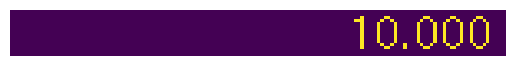

In [249]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

#imagem = Image.open("screenshot10.png")

def preprocess_image(image_path):
    
    img = Image.open(image_path)
    img = img.convert('L')  # Converta para escala de cinza
    threshold = 185       # Valor de limiar para binarização
    img = img.point(lambda p: p > threshold and 255)

    return img

image_path = "screenshot5.png"  # Substitua pelo caminho da sua imagem
imagem = preprocess_image(image_path)

for i in range(11):
    psm = 3 + i
    for j in range (3):
        oem = j
        
        config = '--psm ' + str(psm) + ' --oem ' + str(oem)
        #if int(''.join(filter(str.isdigit, pytesseract.image_to_string(imagem, config=config)))) == 100:
        if ''.join(filter(str.isdigit, pytesseract.image_to_string(imagem, config=config))) == '10000':
            print(psm, oem)
        #print(''.join(filter(str.isdigit, pytesseract.image_to_string(imagem, config=config))))


plt.imshow(imagem)
plt.axis('off')  # Remover eixos e rótulos
plt.show()

In [68]:

x = []
for i in range(len(turnoD)):
    if turnoD[i] == 1:
        k = ((10 - mediaRetorno)/(10))*((retorno)/bb)*abs((((poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*(rating/16.9)**2 - apostaMinimaD[i])/(poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*winrateD[i]))**0.5
        print(((10 - mediaRetorno)/(10)))
    else:
        k = ((10 - mediaRetorno)/(10))*((retorno)/bb)*abs((((poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*winrateD[i] - apostaMinimaD[i])/(poteD[i] + apostaMinimaD[i]*faltamD[i]/(1 + (apostaMinimaD[i]/bb)**(1/2)))*winrateD[i]))**0.5
    k = k*((15 - mediaRetorno)/15 - abs(retorno)*mediaRetorno/(15*retorno))
    x.append(k)

#(sum(pagueiD)/bb)*x[-1]*(faltamD[-1] - mediaFaltam[turnoD[-1] - 1])
#faltamP[turnoD[-1] - 1] = faltamP[turnoD[-1] - 1] - (abs(c)**(1/3))*(abs(c)/c)*0.00004
retorno

0.7986190476190476


30000

In [119]:
(pagueiD[j]/bb)*(i/turnoD[-1])*x[j]*(pessoasD[j] - mediaPessoas[i])
(abs(c)**(1/3))*(abs(c)/c)*0.0001

0.0008203613010538629

In [42]:
winrate = 0.6
pessoas = 3
faltam = 2
bb = 100
pagar = 400
winrate = winrate**(1 + (pessoas - 1 - faltam*(1 - 1/(1 + pagar/(50*bb))) ))
print(winrate)
winrate = 0.6**pessoas
winrate = winrate**(1 - (faltam*(1 - 1/(1 + pagar/(50*bb))))/pessoas)
print(winrate)
print(0.6**pessoas)

0.2329808538499872
0.2329808538499872
0.21599999999999997


In [9]:
(1 - (faltam*(1 - 1/(1 + pagar/(50*bb))))/pessoas)

0.6129032258064517

In [18]:
bb = 100
pessoas = 3
faltam = 1
pagar = 1200
pote = 10000
mesmoTurno = 1
winrate = 0.6
estPessoas = 3
pago = (pote + (pagar + apostado[0])*(estPessoas + faltam - pessoas))*winrate
aposto = (pago/3)*pessoas**0.5
#aposto = (2*bb + pote + (pagar + apostado[0])*faltam/(1 + ((pagar + apostado[0])/bb)**(1/2)))*(10**(winrate-1)*winrate**4)*(1 + 4*bb**(1/2)/pote**(1/2))
print(pago)
print(aposto)

6720.0
2240.0


In [42]:
deck = [str(card[0]) + card[1] for card in list(product(values, suits))]
#remove do baralho as cartas que estão na mão e na mesa
deck.pop(deck.index(mao[0])) 
deck.pop(deck.index(mao[1]))
for i in mesa:
    if i in deck:
        deck.pop(deck.index(i))

nCartas = num + pessoas*2
t = []
for u in range(nCartas):
    a = random.choices(deck)
    while a in t:
        a = random.choices(deck)
    t.append(a)
print(t)
t = random.sample(deck, nCartas)
print(t)

[['10p'], ['3c'], ['2e'], ['9c']]
['14p', '13p', '12e', '6c']


In [54]:
time.sleep(2)
time.position

8000.0
8000.0
4756.828460010885
9513.65692002177
3509.530701206647
10528.59210361994
2828.4271247461897
11313.70849898476
2392.558049953953
11962.790249769763
